In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=[],
                        text_compositions=['bi_lstm'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

Number of inputs to dense layer: 156


# Train model 

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=4096,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 266s 616us/step - loss: 1.4699e-04 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 0.9993


# Learning curves

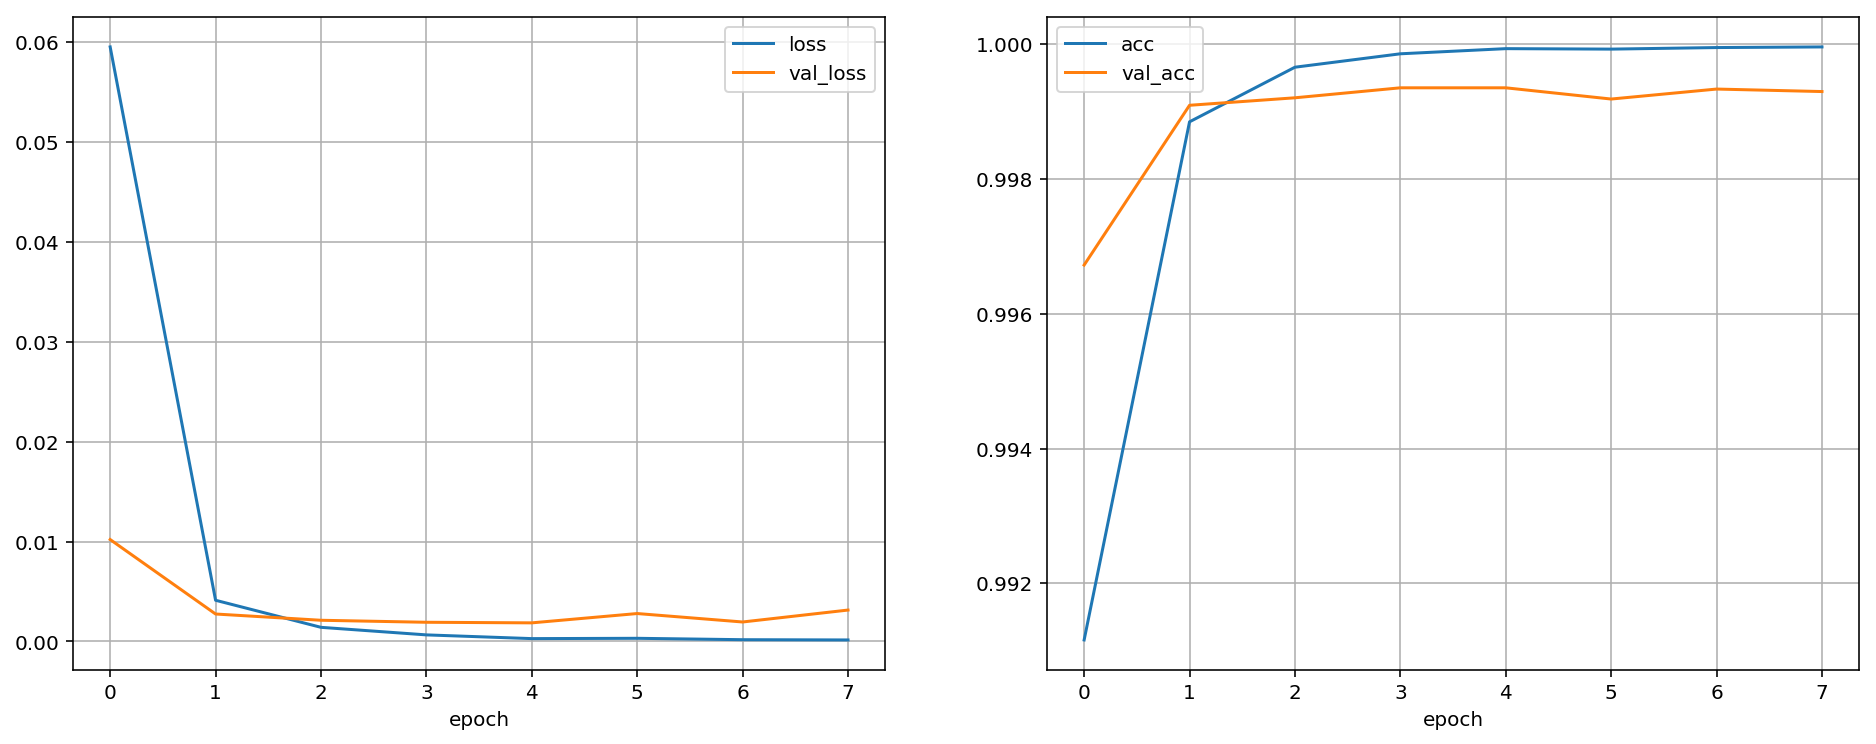

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [7]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53429
          1       0.98      0.96      0.97       575

avg / total       1.00      1.00      1.00     54004

[[53416    13]
 [   22   553]]


In [8]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
41162,journals/vldb/SheikholeslamiCZ00,WAVECLUSTER : A Wavelet Based Clustering Approach for Spatial Data in Very Large Databases,"G Sheikholeslami , S Chatterjee , A Zhang",VLDB J.,2000,eFgoWIVr71IJ,a wavelet-based clustering approach for spatial data in very large Databases The VLDB Journal,"F Sheikholeslami , S Chatterjee , AZ WAVECLUSTER",NaN,0.0
2409,conf/sigmod/DeshpandeNGS03a,IRISNET : Internet-scale resource-intensive Sensor Services,"A Deshpande , S Nath , P Gibbons , S Seshan",SIGMOD Conference,2003,pF6EW_yKYyYJ,IRISNET : An Architecture for Internet-scale Sensing Services,"S Nath , A Deshpande , Y Ke , PB Gibbons , B Karp , S","PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON VERY LARGE … ,",2003.0
52513,conf/sigmod/ParkKKLPC98,Xmas : An Extensible main-memory Storage System for High-Performance Applications,"J Park , Y Kwon , K Kim , S Lee , B Park , S Cha",SIGMOD Conference,1998,F8CacVSkztEJ,Xmas : an extensible main-memory storage system,"SK Cha , JH Park , BD Park","Proceedings of the sixth international conference on … ,",1997.0
43004,conf/sigmod/ChristophidesACS94,From Structured Documents to Novel Query Facilities,"V CHRISTOPHIDES , S Abiteboul , S CLUET , M Scholl",SIGMOD Conference,1994,T8v6sQ1R3zoJ,"V. ANDABITEBOUL , S. CLUET , and M. SCHOLL. From structured documents to novel query facilities",S CHRISTOPHIDES,NaN,0.0
48825,journals/sigmod/Vianu03,A Web odyssey : from codd to XML,V Vianu,SIGMOD Record,2003,bvcQt7zFoAoJ,from Codd to XML,"V Vianu , AW Odyssey","Proceedings of the twentieth ACM SIGMOD-SIGACT-SIGART … ,",0.0


# Save model and histories 

In [9]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-2-full.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-2-full')

# Test model 

In [10]:
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99966   0.99989   0.99978     53502
          1    0.98778   0.96421   0.97586       503

avg / total    0.99955   0.99956   0.99955     54005

[[53496     6]
 [   18   485]]
